In [1]:
from pkg.d2l.d2l import torch as d2l
import torch
import torch.nn.init as init
from torch import nn
from mamba_ssm import Mamba2
from transformers.models.mamba2.modeling_mamba2 import (
    Mamba2RMSNorm,
    Mamba2Config,
    Mamba2Block,
    Mamba2Model,
)
from mamba_ssm.models.mixer_seq_simple import create_block

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [2]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）

    Defined in :numref:`sec_rnn_scratch`"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            # grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            # grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * d2l.size(y), d2l.size(y))
    return d2l.math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [3]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False, updater="SGD"):
    """训练模型（定义见第8章）

    Defined in :numref:`sec_rnn_scratch`"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    if isinstance(net, nn.Module):
        if updater.lower() == "sgd":
            updater = torch.optim.SGD(net.parameters(), lr)
        else:
            updater = torch.optim.Adam(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: d2l.predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

# RNN

In [4]:
class RNNModel(nn.Module):
    """循环神经网络模型

    Defined in :numref:`sec_rnn-concise`"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)
        self.emb = nn.Embedding(vocab_size, self.rnn.input_size)

    def forward(self, inputs, state):
        # X = torch.functional.F.one_hot(inputs.T.long(), self.vocab_size).cuda()
        # X = X.to(torch.float32)
        X = self.emb(inputs.T.long())
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

困惑度 1.0, 104857.0 词元/秒 cuda
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


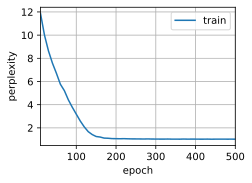

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, "cuda"
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
# model = d2l.RNNModel(lstm_layer, len(vocab))
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# Mamba2

In [6]:
class MambaEncoder(nn.Module):
    def __init__(self, d_model, d_state, d_conv, expand, headdim, bidirectional_method='add'):
        super(MambaEncoder, self).__init__()
        self.d_model = d_model
        self.bidirectional_method = bidirectional_method
        
        self.mamba = Mamba2(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand, headdim=headdim)

        # Norm and feed-forward network layer
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Linear(d_model * 4, d_model)
        )
        if self.bidirectional_method=='concat':
            self.reducer = nn.Linear(d_model * 2, d_model)
            
    def forward(self, x):
        # Residual connection of the original input
        residual = x
        
        # Forward Mamba
        x_norm = self.norm1(x)
        mamba_out_forward = self.mamba(x_norm)

        # Backward Mamba
        x_flip = torch.flip(x_norm, dims=[1])  # Flip Sequence
        mamba_out_backward = self.mamba(x_flip)
        mamba_out_backward = torch.flip(mamba_out_backward, dims=[1])  # Flip back

        # Combining forward and backward
        if self.bidirectional_method=='add':
            mamba_out = mamba_out_forward + mamba_out_backward
        elif self.bidirectional_method=='concat':
            mamba_out = torch.cat([mamba_out_forward, mamba_out_backward], dim=-1)
            mamba_out = self.reducer(mamba_out)
        else:
            raise NotImplementedError(f'bidirectional_method {self.bidirectional_method} is not implemented.')
        
        mamba_out = self.norm2(mamba_out)
        ff_out = self.feed_forward(mamba_out)

        output = ff_out + residual
        return output

class BiMambaStack(nn.Module):
    def __init__(self, n_layers, dim, d_state, d_conv, expand, headdim, bidirectional_method='add'):
        super().__init__()
        self.backbone = nn.Sequential(
            *[MambaEncoder(dim, d_state, d_conv, expand, headdim, bidirectional_method=bidirectional_method) for _ in range(n_layers)]
        )
    def forward(self, seq):
        return self.backbone(seq)

In [7]:
class FBMambaBlock(nn.Module):
    def __init__(
        self,
        d_model=128,  # Model dimension d_model
        d_state=64,  # SSM state expansion factor, typically 64 or 128
        d_conv=4,  # Local convolution width
        expand=2,  # Block expansion factor
        headdim=32,  # Head dimension, typically 64 or 128
    ):
        super(FBMambaBlock, self).__init__()
        self.forward_mamba2 = Mamba2(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand,
            headdim=headdim,
        )

        self.backward_mamba2 = Mamba2(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand,
            headdim=headdim,
        )

    def forward(self, input):
        forward_f = input
        forward_f_output = self.forward_mamba2(forward_f)
        backward_f = torch.flip(input, [1])
        backward_f_output = self.backward_mamba2(backward_f)
        backward_f_output2 = torch.flip(backward_f_output, [1])
        output = torch.cat([forward_f_output + input, backward_f_output2 + input], -1)
        return output

In [8]:
class M2Model(nn.Module):
    """循环神经网络模型

    Defined in :numref:`sec_rnn-concise`"""

    def __init__(
        self,
        vocab_size=28,
        config=None,
        d_model=128,  # Model dimension d_model
        d_state=64,  # SSM state expansion factor, typically 64 or 128
        d_conv=4,  # Local convolution width
        expand=2,  # Block expansion factor
        headdim=32,  # Head dimension, typically 64 or 128
        bidirectional_method="add",
        **kwargs,
    ):
        super(M2Model, self).__init__(**kwargs)
        self.vocab_size = config.vocab_size if config else vocab_size
        self.num_hiddens = config.hidden_size if config else d_model
        # self.m2 = BiMambaStack(
        #     num_layers,
        #     d_model,
        #     d_state,
        #     d_conv,
        #     expand,
        #     headdim,
        #     bidirectional_method=bidirectional_method,
        # )
        # self.m2 = Mamba2(
        #     d_model=d_model,  # Model dimension d_model
        #     d_state=d_state,  # SSM state expansion factor, typically 64 or 128
        #     d_conv=d_conv,  # Local convolution width
        #     expand=expand,  # Block expansion factor
        #     headdim=headdim,  # Head dimension, typically 64 or 128
        # )
        # self.m2 = nn.ModuleList([Mamba2Block(config, layer_idx=idx) for idx in range(config.num_hidden_layers)])

        # self.m2 = Mamba2Model(config)
        self.m2 = FBMambaBlock(
            d_model=d_model,  # Model dimension d_model
            d_state=d_state,  # SSM state expansion factor, typically 64 or 128
            d_conv=d_conv,  # Local convolution width
            expand=expand,  # Block expansion factor
            headdim=headdim,  # Head dimension, typically 64 or 128
        )

        self.emb = nn.Embedding(self.vocab_size, self.num_hiddens)
        self.linear = nn.Linear(self.num_hiddens*2, self.vocab_size)
        # self.norm_f = Mamba2RMSNorm(config.hidden_size, eps=config.layer_norm_epsilon)
        self.init()

    def forward(self, inputs, state):
        # X = torch.functional.F.one_hot(inputs.T.long(), self.vocab_size).T.cuda()
        # X = X.to(torch.float32)
        X = self.emb(inputs.T.long())
        Y = self.m2(X)
        # Y = self.m2(inputs.T.long())["last_hidden_state"]
        # Y = self.emb(inputs.T.long())
        # for layer in self.m2:
        #     Y = layer(Y) + Y
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        return torch.tensor([], device=device)

    def init(self):
        init.kaiming_uniform_(self.linear.weight, nonlinearity="relu")
        init.constant_(self.linear.bias, 0.0)

In [9]:
class MyMamba2Config(Mamba2Config):
    model_type = "mamba2"
    def __init__(
        self,
        symbol_size=32768,
        *args,
        **kwargs
    ):
        self.symbol_size = symbol_size
        super().__init__(*args, **kwargs)

In [10]:
# hidden_size=128
# expand=2
# head_dim=32
# config = Mamba2Config(
#     vocab_size=28,
#     hidden_size=hidden_size,
#     head_dim=head_dim,
#     num_heads=expand * hidden_size // head_dim,
#     expand=expand,
#     num_hidden_layers=4,
#     state_size=64,
#     n_groups=1,
# )
hidden_size=256
expand=2
head_dim=64
config = Mamba2Config(
    vocab_size=28,
    hidden_size=hidden_size,
    head_dim=head_dim,
    num_heads=expand * hidden_size // head_dim,
    expand=expand,
    num_hidden_layers=8,
    state_size=64,
    n_groups=2,
)

In [11]:
config.expand, config.hidden_size, config.n_groups, config.state_size, config.num_heads

(2, 256, 2, 64, 8)

In [12]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_inputs = vocab_size
m2_model = M2Model(
    len(vocab),
    # config=config,
    d_model=256,  # Model dimension d_model
    d_state=64,  # SSM state expansion factor, typically 64 or 128
    d_conv=4,  # Local convolution width
    expand=2,  # Block expansion factor
    headdim=64,  # Head dimension, typically 64 or 128
)
m2_model = m2_model.to(device)

In [13]:
# x = torch.randint(0, 27, (32,35)).to(device)
# emb = m2_model.emb(x)
# emb.shape

In [14]:
# m2_model.m2(emb)

困惑度 1.0, 35659.8 词元/秒 cuda:0
time traveller us us us us us us us us us us us us us us us us u
traveller us us us us us us us us us us us us us us us us u


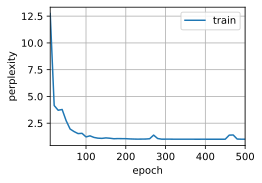

In [15]:
num_epochs, lr = 500, 5e-4
train_ch8(m2_model, train_iter, vocab, lr, num_epochs, device, updater="Adam")

# Transformers

In [16]:
# 定义参数
d_model = 512  # 模型维度
nhead = 8      # 多头注意力机制的头数
dim_feedforward = 2048  # 前馈网络的维度
dropout = 0.1  # Dropout 概率

In [17]:
# 创建 TransformerEncoderLayer 实例
encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout).cuda()

In [18]:
# 生成一个示例输入
src = torch.rand(10, 32, d_model).cuda()  # (序列长度, 批量大小, 模型维度)

# 通过 TransformerEncoderLayer 处理输入
output = encoder_layer(src)

In [19]:
src.shape, output.shape

(torch.Size([10, 32, 512]), torch.Size([10, 32, 512]))

In [20]:
class TransformerModel(nn.Module):
    """Transformer模型

    Defined in :numref:`sec_rnn-concise`"""
    def __init__(self, vocab_size, d_model=512, n_head=8, num_layers=6, dim_feedforward=2048, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.vocab_size = vocab_size
        self.num_hiddens = d_model
        self.emb = nn.Embedding(vocab_size, d_model)
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model, n_head, dim_feedforward, dropout) for _ in range(num_layers)
        ])
        self.linear = nn.Linear(d_model, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.emb.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, inputs, state=None):
        # 输入形状为 (batch_size, sequence_length)
        X = self.emb(inputs)  # 输出形状为 (batch_size, sequence_length, d_model)
        X = X.permute(1, 0, 2)  # 转换为 (sequence_length, batch_size, d_model)
        for layer in self.transformer_layers:
            X = layer(X)
        X = X.permute(1, 0, 2)  # 转换回 (batch_size, sequence_length, d_model)
        output = self.linear(X.reshape((-1, X.shape[-1])))  # 输出形状为 (batch_size, sequence_length, vocab_size)
        return output, None

    def begin_state(self, device, batch_size=1):
        # Transformer 不需要显式的初始状态
        return None

In [49]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_inputs = vocab_size
transformer_model = TransformerModel(
    len(vocab),
    d_model=512,
    n_head=8
)
transformer_model = transformer_model.to(device)

In [22]:
# for X, Y in train_iter: break

In [23]:
# X.shape

In [24]:
# X = X.to(device)
# # transformer_model(X.to(device))[0].shape
# inputs = transformer_model.emb(X)  # 输出形状为 (batch_size, sequence_length, d_model)
# inputs.shape

In [25]:
# inputs = inputs.permute(1, 0, 2)  # 转换为 (sequence_length, batch_size, d_model)
# for layer in transformer_model.transformer_layers:
#     inputs = layer(inputs)
# inputs = inputs.permute(1, 0, 2)  # 转换回 (batch_size, sequence_length, d_model)
# inputs.shape

In [26]:
# output = transformer_model.linear(inputs.reshape((-1, inputs.shape[-1])))  # 输出形状为 (batch_size, sequence_length, vocab_size)

In [27]:
# output.shape

In [28]:
# Y.T.reshape(-1).shape

困惑度 17.5, 28389.0 词元/秒 cuda:0
time traveller                                                  
traveller                                                  


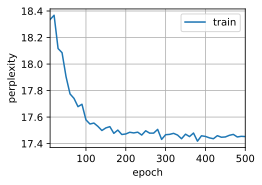

In [50]:
num_epochs, lr = 500, 1e-3
train_ch8(transformer_model, train_iter, vocab, lr, num_epochs, device, updater="Adam")

# Parameters

In [30]:
from thop import profile

In [31]:
dummy_input = torch.ones(32, 35).cuda()

In [32]:
flops, params = profile(m2_model, (dummy_input,None))
print('flops: ', flops, 'params: ', params)
print('flops: %.2f M, params: %.2f M' % (flops / 1000000.0, params / 1000000.0))

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
flops:  681246720.0 params:  608284.0
flops: 681.25 M, params: 0.61 M


In [33]:
for x,y in train_iter:
    break

In [34]:
state = model.begin_state(batch_size=batch_size, device=device)

In [35]:
model.eval()

RNNModel(
  (rnn): LSTM(28, 256)
  (linear): Linear(in_features=256, out_features=28, bias=True)
  (emb): Embedding(28, 28)
)

In [36]:
model(x.cuda(),state)

(tensor([[ -1.4301,   2.7513,   2.9352,  ...,  -1.9270,  -0.4947,  -1.3379],
         [ -2.6532, -15.9765,   0.1907,  ...,  -2.6391,   1.7383,  -0.6799],
         [ -2.6532, -15.9765,   0.1907,  ...,  -2.6391,   1.7383,  -0.6799],
         ...,
         [ -5.9695, -11.5434,  -8.2908,  ...,   0.4539,  -2.0632,  -2.5745],
         [ -6.6366,   2.7560,   7.8226,  ...,  -0.7814,  -0.0189,  -2.4049],
         [ -7.8481, -17.5394,   4.6651,  ...,  -3.4059,   0.4111,  -3.3811]],
        device='cuda:0', grad_fn=<AddmmBackward0>),
 (tensor([[[-0.7616, -0.1639,  0.5462,  ..., -0.1983, -0.1945,  0.7587],
           [ 0.4777,  0.6724, -0.3567,  ..., -0.2146, -0.7882, -0.5784],
           [ 0.1554,  0.3690,  0.3019,  ..., -0.8622, -0.8057,  0.1341],
           ...,
           [-0.9584,  0.7413, -0.6866,  ..., -0.7102,  0.9688, -0.6699],
           [ 0.7348, -0.5881, -0.8266,  ...,  0.7730, -0.1383,  0.7215],
           [ 0.0784, -0.7566,  0.2578,  ...,  0.9004,  0.6802,  0.8910]]],
         device

In [37]:
flops, params = profile(model, (x.cuda(),state))
print('flops: ', flops, 'params: ', params)
print('flops: %.2f M, params: %.2f M' % (flops / 1000000.0, params / 1000000.0))

[INFO] Register count_lstm() for <class 'torch.nn.modules.rnn.LSTM'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
flops:  338329600.0 params:  300060.0
flops: 338.33 M, params: 0.30 M


In [38]:
flops, params = profile(transformer_model, (x.cuda(),None))
print('flops: ', flops, 'params: ', params)
print('flops: %.2f M, params: %.2f M' % (flops / 1000000.0, params / 1000000.0))

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
flops:  14136442880.0 params:  12624924.0
flops: 14136.44 M, params: 12.62 M


In [39]:
state[0].shape

torch.Size([1, 32, 256])

In [40]:
for x,y in train_iter:
    break

In [41]:
x.shape

torch.Size([32, 35])

In [42]:
emb = nn.Embedding(28, 256)

In [43]:
torch.functional.F.one_hot(x.T.long(), 28).shape

torch.Size([35, 32, 28])

In [44]:
emb(x.T).shape

torch.Size([35, 32, 256])

In [45]:
x[0]

tensor([ 3,  5, 13,  2,  1,  3, 10,  4, 22,  2, 12, 12,  2, 10,  1, 16,  7, 10,
         1,  8,  7,  1,  5,  3,  1, 17,  5, 12, 12,  1, 21,  2,  1, 15,  7])

In [46]:
y.shape

torch.Size([32, 35])

In [47]:
input = torch.functional.F.one_hot(x.T.long(), vocab_size)
input = input.to(torch.float32).to("cuda")
input.shape

torch.Size([35, 32, 28])

In [48]:
m2_layer(input).shape

NameError: name 'm2_layer' is not defined